# Topology Optimization Using Reinforcment Learning Source Code
## Imports:

In [111]:
import sys
import os
import time
import random
import math
import datetime

import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt


import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor

%load_ext tensorboard
import tensorflow as tf

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Parameters
#### Design Parameters

In [112]:
HEIGHT = 4
"""The height of the design space."""

WIDTH = 4
"""The width of the design space."""

bound_nodes_list = [(0, 0), (HEIGHT-1, 0)]
"""A list containing the coordinates of the nodes that are bound in the 
design space."""

loaded_nodes_list = [(HEIGHT-1, WIDTH-1)]
"""A list containing the coordinates of the nodes that are loaded in the 
design space."""

'A list containing the coordinates of the nodes that are loaded in the \ndesign space.'

#### Physical Parameters

In [113]:
#Aluminium 6061

YOUNG_MODULUS = 68
"""The Value of the Young modulus of the used material"""

POISSON_RATIO = 0,32
"""The value of the Poisson ratio of the used material"""

YIELD_STRENGTH = 275
"""The specific yield strength of the used material in MPa"""

STRAIN_LIMIT = 0.002
"""The specific strain limit of the used material"""


'The specific strain limit of the used material'

#### Technical Parameters

In [114]:
NUMBER_SUBPROCESSES = 1
"""The number of subprocesses to be used in the multiprocessing 
environment."""

LOG_DIR = "log/"
"""The directory of where to save the best model."""

TS_BOARD_DIR = "ts_board/"
"""The directory of where to save the tensorboard logs."""

TIMESTEPS = 5e5
"""The number of timesteps to be used during the training of the model."""
#5e6

'The number of timesteps to be used during the training of the model.'

In [115]:
DESIGN = 0
"""The Constant Used to access the design dimension of the design space"""
BOUND = 1
"""The Constant used to access the Boundary layout of the design space"""
LOADED_X = 2
"""The Constant used to access the nodes which are loaded in the x direction"""
LOADED_Y = 3
"""The Constant used to access the a which are loaded in the y direction"""

mpl.rcParams['image.cmap'] = 'YlOrBr'

## Matrix Operation Functions

In [116]:
def convert_all(coords, matrix_dim):
    """
    Convert all relative indices in a list of coordinates to absolute indices.

    Parameters:
    coords (list): The list of coordinates with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    list: The list of coordinates with absolute indices.
    """
    return list(map(lambda coord: convert_relative_to_absolute(coord, matrix_dim), 
                    coords))

def convert_relative_to_absolute(coord, matrix_dim):
    """
    Convert relative indices in a coordinate to absolute indices.

    Parameters:
    coord (tuple): The coordinate with potentially relative indices.
    matrix_dim (tuple): The dimensions of the matrix.

    Returns:
    tuple: The coordinate with absolute indices.
    """
    return tuple(dim + i if i < 0 else i for i, dim in zip(coord, matrix_dim))

In [117]:
def scale_matrix(matrix, target_rows, target_cols):
    """A function that scales a given matrix to a target size. 
    The scaling is done by repeating the elements of the matrix.
    ----------
    Parameters:\n
    - matrix : numpy.ndarray
        - The matrix that should be scaled.
    - target_rows : int
        - The target number of rows of the scaled matrix.
    - target_cols : int
        - The target number of columns of the scaled matrix.
    -------
    Returns:\n
    - numpy.ndarray
        - The scaled matrix.
    """
    original_rows = len(matrix)
    original_cols = len(matrix[0]) if original_rows > 0 else 0
    
    # Calculate scale factors
    row_scale_factor = target_rows // original_rows
    col_scale_factor = target_cols // original_cols
    
    # Scale the matrix
    scaled_matrix = []
    for row in matrix:
        # Scale each row horizontally
        scaled_row = []
        for element in row:
            scaled_row.extend([element] * col_scale_factor)
        
        # Scale the matrix vertically
        for _ in range(row_scale_factor):
            scaled_matrix.append(list(scaled_row))
    
    # Handle any remaining rows due to non-integer scale factors
    additional_rows = target_rows % original_rows
    if additional_rows > 0:
        for i in range(additional_rows):
            scaled_matrix.append(list(scaled_matrix[i]))
    
    # Handle any remaining columns due to non-integer scale factors
    additional_cols = target_cols % original_cols
    if additional_cols > 0:
        for row in scaled_matrix:
            row.extend(row[:additional_cols])
    
    return np.array(scaled_matrix)

## FEM-Analysis Helper Functions

In [118]:
def shape(xi):
	"""Shape functions for a 4-node, isoparametric element
		N_i(xi,eta) where i=[1,2,3,4]
		Input: 1x2,  Output: 1x4"""
	xi,eta = tuple(xi)
	N = [(1.0-xi)*(1.0-eta), (1.0+xi)*(1.0-eta), (1.0+xi)*(1.0+eta), (1.0-xi)*(1.0+eta)]
	return 0.25 * np.array(N)
def gradshape(xi):
	"""Gradient of the shape functions for a 4-node, isoparametric element.
		dN_i(xi,eta)/dxi and dN_i(xi,eta)/deta
		Input: 1x2,  Output: 2x4"""
	xi,eta = tuple(xi)
	dN = [[-(1.0-eta),  (1.0-eta), (1.0+eta), -(1.0+eta)],
		  [-(1.0-xi), -(1.0+xi), (1.0+xi),  (1.0-xi)]]
	return 0.25 * np.array(dN)

### Mesh Generation Functions
The FEM-Analysis-Function works using a mesh made up of Elements, which in turn are made up of connedted Nodes.
The following Function transform the Design Matrix used within the Reinforcement Learning process and creates Nodes, connections and Elements,
as well as asigning load and bounding conditions to the corresponding Nodesm, so that the FEM-Analysis can be performed on the Design Matrix.

In [119]:
def assemble_load(nodes, load, f):
  for load_data in load:
    node_index = load_data[0]
    dof = load_data[1]
    magnitude = load_data[2]
    global_dof = 2 * node_index + dof - 1
    f[global_dof] += magnitude

def extract_nodes_and_elements(design):
    nodes = []
    elements = []
    node_id = 0
    node_map = {}

    existing_elements = set()  # Store unique element combinations

    filled_indices = np.where(design == 1)

    for i, j in zip(*filled_indices):
        # Define nodes for the filled pixel
        pixel_nodes = [
            (i, j), (i, j+1),
            (i+1, j), (i+1, j+1)
        ]

        for node in pixel_nodes:
            if node not in node_map:
                node_map[node] = node_id
                nodes.append([float(node[0]), float(node[1])])
                node_id += 1

        # Define elements by connecting nodes as two triangles
        n1, n2, n3, n4 = (node_map[(i, j)], node_map[(i, j+1)],
                         node_map[(i+1, j)], node_map[(i+1, j+1)])

        # Check if the element or its reversed version already exists
        element_tuple = tuple(sorted([n1, n2, n3, n4]))
        if element_tuple not in existing_elements:
            # Create two triangles
            elements.append([n1, n3, n4, n1])  # Triangle 1
            elements.append([n1, n4, n2, n1])  # Triangle 2
            existing_elements.add(element_tuple)

    return nodes, elements, node_map


def extract_boundary_conditions(bounded, loaded_x, loaded_y, node_map,):
    boundary_conditions = []
    rows, cols = bounded.shape


    for i in range(rows):
        for j in range(cols):
            if bounded[i, j] != 0:
                # Apply boundary conditions to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        if(bounded[i, j] == 1):
                            boundary_conditions.append([node_id, 1, 1, 0.0])  # Example: fixed in x-direction
                        if(bounded[i, j] == 2):
                            boundary_conditions.append([node_id, 2, 2, 0.0])  # Example: fixed in y-direction
                        if(bounded[i, j] == 3):
                            boundary_conditions.append([node_id, 1, 1, 0.0])  # Example: fixed in x-direction
                            boundary_conditions.append([node_id, 2, 2, 0.0])  # Example: fixed in y-direction


    return boundary_conditions

# n, 1, 2, 0.0 'fixed in both directions
# n, 1, 1 ,0.0 'fixed in dof 1 direction
# n, 1, 1, 0.1 moved in dof1 free in dof2
# n , 2, 2 0.0 fixed in dof2 direction

def extract_loads(loaded_x, loaded_y, node_map):
    """Extracts load information from the loaded matrices.

    Args:
        loaded_x: Numpy array representing the x-component of the load.
        loaded_y: Numpy array representing the y-component of the load.
        node_map: Dictionary mapping node coordinates to node IDs.

    Returns:
        List of load information, where each element is a tuple (node_id, load_x, load_y).
    """

    loads = []
    rows, cols = loaded_x.shape

    for i in range(rows):
        for j in range(cols):
            if loaded_x[i, j] != 0 or loaded_y[i, j] != 0:
                # Apply loads to all corners of the pixel
                pixel_nodes = [
                    (i, j), (i, j+1),
                    (i+1, j), (i+1, j+1)
                ]
                for node in pixel_nodes:
                    node_id = node_map.get(node)
                    if node_id is not None:
                        if loaded_x[i, j] != 0:
                            loads.append([node_id, 1, loaded_x[i, j]])
                        if loaded_y[i, j] != 0:
                            loads.append([node_id, 2, loaded_y[i, j]])

    return loads


def extract_fem_data(matrix):
    design = matrix[DESIGN, :, :]
    bounded = matrix[BOUND, :, :]
    loaded_x = matrix[LOADED_X, :, :]
    loaded_y = matrix[LOADED_Y, :, :]

    nodes, elements, node_map = extract_nodes_and_elements(design)
    boundary_conditions = extract_boundary_conditions(bounded, loaded_x, loaded_y, node_map)
    loads = extract_loads(loaded_x, loaded_y, node_map)

    return (nodes, elements, boundary_conditions, loads)

###  Mesh Plotting Functions
Here are two functions for plotting the generated Mesh.
- **plot_mesh** visualises the created Nodes and connections.
- **plot_contour** visualises the Results of the FEM-Analysis

In [120]:
def plot_mesh(nodes, conn, width=10, height=8):
    nodes = np.array(nodes)  # Convert nodes to a NumPy array
    plt.figure(figsize=(width, height))  # Set the figure size
    for element in conn:
        x = [nodes[i][1] for i in element]  # Swap x and y
        y = [-nodes[i][0] for i in element]  # Swap x and y and negate y
        plt.plot(x, y, 'b-')
    plt.scatter(nodes[:, 1], -nodes[:, 0], color='red', s=10)  # Swap x and y and negate y
    
    # Add text annotations for each node
    for i, (x, y) in enumerate(nodes):
        plt.text(y, -x, str(i+1), fontsize=20, ha='right')
    
    plt.axis('equal')
    plt.show()

def plot_contour(nodes, u, node_stress, node_strain, conn, plot_type='e11'):
    xvec = []
    yvec = []
    res  = []

    for ni, pt in enumerate(nodes):
        xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
        yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
        if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
        if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
        if plot_type == 's11': res.append(node_stress[ni][0])     # s11
        if plot_type == 's22': res.append(node_stress[ni][1])     # s22
        if plot_type == 's12': res.append(node_stress[ni][2])     # s12
        if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
        if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
        if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

    tri = []
    for c in conn:
        tri.append([c[0], c[1], c[2]])  # First triangle
        tri.append([c[0], c[2], c[3]])  # Second triangle

    t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
    plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
    plt.grid()
    plt.colorbar(t)
    plt.title(plot_type)
    plt.axis('equal')
    plt.show()


## FEM-Analysis Function

In [121]:
def FEM(nodes, conn, boundary, load, plot_flag):
    
        nodes = np.array(nodes)
        num_nodes = len(nodes)
        #print('   number of nodes:', len(nodes))
        #print('   number of elements:', len(conn))
        #print('   number of displacement boundary conditions:', len(boundary))

        ###############################
        # Plane-strain material tangent (see Bathe p. 194)
        # C is 3x3
        E = 100.0
        v = 0.3
        C = E/(1.0+v)/(1.0-2.0*v) * np.array([[1.0-v, v, 0.0], [v, 1.0-v, 0.0], [0.0, 0.0, 0.5-v]])
        ###############################
        # Make stiffness matrix
        # if N is the number of DOF, then K is NxN
        K = np.zeros((2*num_nodes, 2*num_nodes))    # square zero matrix
        # 2x2 Gauss Quadrature (4 Gauss points)
        # q4 is 4x2
        q4 = np.array([[-1,-1],[1,-1],[-1,1],[1,1]]) / math.sqrt(3.0)
        # print('\n** Assemble stiffness matrix')
        # strain in an element: [strain] = B    U
        #                        3x1     = 3x8  8x1
        #
        # strain11 = B11 U1 + B12 U2 + B13 U3 + B14 U4 + B15 U5 + B16 U6 + B17 U7 + B18 U8
        #          = B11 u1          + B13 u1          + B15 u1          + B17 u1
        #          = dN1/dx u1       + dN2/dx u1       + dN3/dx u1       + dN4/dx u1
        B = np.zeros((3,8))
        # conn[0] is node numbers of the element
        for c in conn:     # loop through each element
            # coordinates of each node in the element
            # shape = 4x2
            # for example:
            #    nodePts = [[0.0,   0.0],
            #               [0.033, 0.0],
            #               [0.033, 0.066],
            #               [0.0,   0.066]]
            nodePts = nodes[c,:]
            Ke = np.zeros((8,8))	# element stiffness matrix is 8x8
            for q in q4:			# for each Gauss point
                # q is 1x2, N(xi,eta)
                dN = gradshape(q)       # partial derivative of N wrt (xi,eta): 2x4
                J  = np.dot(dN, nodePts).T # J is 2x2
                dN = np.dot(np.linalg.inv(J), dN)    # partial derivative of N wrt (x,y): 2x4
                # assemble B matrix  [3x8]
                B[0,0::2] = dN[0,:]
                B[1,1::2] = dN[1,:]
                B[2,0::2] = dN[1,:]
                B[2,1::2] = dN[0,:]
                # element stiffness matrix
                Ke += np.dot(np.dot(B.T,C),B) * np.linalg.det(J)
            # Scatter operation
            for i,I in enumerate(c):
                for j,J in enumerate(c):
                    K[2*I,2*J]     += Ke[2*i,2*j]
                    K[2*I+1,2*J]   += Ke[2*i+1,2*j]
                    K[2*I+1,2*J+1] += Ke[2*i+1,2*j+1]
                    K[2*I,2*J+1]   += Ke[2*i,2*j+1]
        ###############################
        # Assign nodal forces and boundary conditions
        #    if N is the number of nodes, then f is 2xN
        f = np.zeros((2*num_nodes))          # initialize to 0 forces
        assemble_load(nodes, load, f)
        # How about displacement boundary conditions:
        #    [k11 k12 k13] [u1] = [f1]
        #    [k21 k22 k23] [u2]   [f2]
        #    [k31 k32 k33] [u3]   [f3]
        #
        #    if u3=x then
        #       [k11 k12 k13] [u1] = [f1]
        #       [k21 k22 k23] [u2]   [f2]
        #       [k31 k32 k33] [ x]   [f3]
        #   =>
        #       [k11 k12 k13] [u1] = [f1]
        #       [k21 k22 k23] [u2]   [f2]
        #       [  0   0   1] [u3]   [ x]
        #   the reaction force is
        #       f3 = [k31 k32 k33] * [u1 u2 u3]
        for i in range(len(boundary)):  # apply all boundary displacements
            nn  = boundary[i][0]
            dof = boundary[i][1]
            val = boundary[i][2]
            j = 2*nn
            if dof == 2: j = j + 1
            K[j,:] = 0.0
            K[j,j] = 1.0
            f[j] = val
        ###############################
        # print('\n** Solve linear system: Ku = f')	# [K] = 2N x 2N, [f] = 2N x 1, [u] = 2N x 1
        u = np.linalg.solve(K, f)
        ###############################
        # print('\n** Post process the data')
        # (pre-allocate space for nodal stress and strain)
        node_strain = []
        node_stress = []
        for ni in range(len(nodes)):
            node_strain.append([0.0, 0.0, 0.0])
            node_stress.append([0.0, 0.0, 0.0])
        node_strain = np.array(node_strain)
        node_stress = np.array(node_stress)

        #print(f'   min displacements: u1={min(u[0::2]):.4g}, u2={min(u[1::2]):.4g}')
        #print(f'   max displacements: u1={max(u[0::2]):.4g}, u2={max(u[1::2]):.4g}')

        avg_u1 = np.mean(u[0::2])
        avg_u2 = np.mean(u[1::2])

        emin = np.array([ 9.0e9,  9.0e9,  9.0e9])
        emax = np.array([-9.0e9, -9.0e9, -9.0e9])
        smin = np.array([ 9.0e9,  9.0e9,  9.0e9])
        smax = np.array([-9.0e9, -9.0e9, -9.0e9])

        # Initialize variables for average calculation
        total_strain = np.zeros(3)
        total_stress = np.zeros(3)
        num_elements = len(conn)

        for c in conn:  # for each element (conn is Nx4)
            nodePts = nodes[c,:]  # 4x2, eg: [[1.1,0.2], [1.2,0.3], [1.3,0.4], [1.4, 0.5]]
            for q in q4:  # for each integration pt, eg: [-0.7,-0.7]
                dN = gradshape(q)  # 2x4
                J  = np.dot(dN, nodePts).T  # 2x2
                dN = np.dot(np.linalg.inv(J), dN)  # 2x4
                B[0,0::2] = dN[0,:]  # 3x8
                B[1,1::2] = dN[1,:]
                B[2,0::2] = dN[1,:]
                B[2,1::2] = dN[0,:]

                UU = np.zeros((8,1))  # 8x1
                UU[0] = u[2*c[0]]
                UU[1] = u[2*c[0] + 1]
                UU[2] = u[2*c[1]]
                UU[3] = u[2*c[1] + 1]
                UU[4] = u[2*c[2]]
                UU[5] = u[2*c[2] + 1]
                UU[6] = u[2*c[3]]
                UU[7] = u[2*c[3] + 1]
                # get the strain and stress at the integration point
                strain = B @ UU  # (B is 3x8) (UU is 8x1) => (strain is 3x1)
                stress = C @ strain  # (C is 3x3) (strain is 3x1) => (stress is 3x1)
                emin[0] = min(emin[0], strain[0][0])
                emin[1] = min(emin[1], strain[1][0])
                emin[2] = min(emin[2], strain[2][0])
                emax[0] = max(emax[0], strain[0][0])
                emax[1] = max(emax[1], strain[1][0])
                emax[2] = max(emax[2], strain[2][0])

                node_strain[c[0]][:] = strain.T[0]
                node_strain[c[1]][:] = strain.T[0]
                node_strain[c[2]][:] = strain.T[0]
                node_strain[c[3]][:] = strain.T[0]
                node_stress[c[0]][:] = stress.T[0]
                node_stress[c[1]][:] = stress.T[0]
                node_stress[c[2]][:] = stress.T[0]
                node_stress[c[3]][:] = stress.T[0]
                smax[0] = max(smax[0], stress[0][0])
                smax[1] = max(smax[1], stress[1][0])
                smax[2] = max(smax[2], stress[2][0])
                smin[0] = min(smin[0], stress[0][0])
                smin[1] = min(smin[1], stress[1][0])
                smin[2] = min(smin[2], stress[2][0])

                # Accumulate total strain and stress for average calculation
                total_strain += strain.T[0]
                total_stress += stress.T[0]

        


        # Calculate average strain and stress
        average_strain = total_strain / num_elements
        average_stress = total_stress / num_elements

        if plot_flag:
            print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
            print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
            print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
            print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
            print(f'   average strains: e11={average_strain[0]:.4g}, e22={average_strain[1]:.4g}, e12={average_strain[2]:.4g}')
            print(f'   average stress:  s11={average_stress[0]:.4g}, s22={average_stress[1]:.4g}, s12={average_stress[2]:.4g}')
            print(f'   average strain/nodes:  s11={abs((average_stress[0])/len(conn))*10000:.4g}, s22={(abs(average_stress[1])/len(conn))*10000:.4g}, s12={(abs(average_stress[2])/len(conn))*10000:.4g}')
            print(f'   average strain/nodes:  e11={abs((average_strain[0])/len(conn))*10000:.4g}, e22={(abs(average_strain[1])/len(conn))*10000:.4g}, e12={(abs(average_strain[2])/len(conn))*10000:.4g}')    
                ##############################
            print('\n** Plot displacement')
            xvec = []
            yvec = []
            res  = []
            plot_type = 'e11'
            for ni, pt in enumerate(nodes):
                xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
                yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
                if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
                if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
                if plot_type == 's11': res.append(node_stress[ni][0])     # s11
                if plot_type == 's22': res.append(node_stress[ni][1])     # s22
                if plot_type == 's12': res.append(node_stress[ni][2])     # s12
                if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
                if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
                if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

            tri = []
            for c in conn:
                tri.append([c[0], c[1], c[2]])  # First triangle
                tri.append([c[0], c[2], c[3]])  # Second triangle

            t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
            plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
            plt.grid()
            plt.colorbar(t)
            plt.title(plot_type)
            plt.axis('equal')
            plt.show()
            print('Done.')
            
        if np.isnan(smax).any() or np.isnan(emax).any() or np.isnan(avg_u1).any() or np.isnan(avg_u2).any() or np.isnan(average_stress).any() or np.isnan(average_strain).any():
            print("NaN detected in FEM results")

        return max(smax), max(emax), avg_u1, avg_u2, len(conn), max(average_stress), max(average_strain), max(u[0::2]), max(u[1::2])

    # except np.linalg.LinAlgError as e:
    #     plot_mesh(nodes, conn)
    #     print("LinAlgError occurded with the following variables:\n", K,"\n", f)
    #     plot_mesh(nodes, conn)
    #     raise e
        # print(f'   min strains: e11={emin[0]:.4g}, e22={emin[1]:.4g}, e12={emin[2]:.4g}')
        # print(f'   max strains: e11={emax[0]:.4g}, e22={emax[1]:.4g}, e12={emax[2]:.4g}')
        # print(f'   min stress:  s11={smin[0]:.4g}, s22={smin[1]:.4g}, s12={smin[2]:.4g}')
        # print(f'   max stress:  s11={smax[0]:.4g}, s22={smax[1]:.4g}, s12={smax[2]:.4g}')
        # print(f'   average strains: e11={average_strain[0]:.4g}, e22={average_strain[1]:.4g}, e12={average_strain[2]:.4g}')
        # print(f'   average stress:  s11={average_stress[0]:.4g}, s22={average_stress[1]:.4g}, s12={average_stress[2]:.4g}')
        # print(f'   average strain/nodes:  s11={abs((average_stress[0])/len(conn))*10000:.4g}, s22={(abs(average_stress[1])/len(conn))*10000:.4g}, s12={(abs(average_stress[2])/len(conn))*10000:.4g}')
        # print(f'   average strain/nodes:  e11={abs((average_strain[0])/len(conn))*10000:.4g}, e22={(abs(average_strain[1])/len(conn))*10000:.4g}, e12={(abs(average_strain[2])/len(conn))*10000:.4g}')    
        #     ###############################
        # # print('\n** Plot displacement')
        # xvec = []
        # yvec = []
        # res  = []
        # plot_type = 'e11'
        # for ni, pt in enumerate(nodes):
        #     xvec.append(pt[1] + u[2*ni+1])  # Swap x and y
        #     yvec.append(-pt[0] - u[2*ni])   # Swap x and y, negate y to rotate 90 degrees
        #     if plot_type == 'u1':  res.append(u[2*ni])                # x-disp
        #     if plot_type == 'u2':  res.append(u[2*ni+1])              # y-disp
        #     if plot_type == 's11': res.append(node_stress[ni][0])     # s11
        #     if plot_type == 's22': res.append(node_stress[ni][1])     # s22
        #     if plot_type == 's12': res.append(node_stress[ni][2])     # s12
        #     if plot_type == 'e11': res.append(node_strain[ni][0])     # e11
        #     if plot_type == 'e22': res.append(node_strain[ni][1])     # e22
        #     if plot_type == 'e12': res.append(node_strain[ni][2])     # e12

        # tri = []
        # for c in conn:
        #     tri.append([c[0], c[1], c[2]])  # First triangle
        #     tri.append([c[0], c[2], c[3]])  # Second triangle

        # t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)
        # plt.scatter(xvec, yvec, marker='o', c='b', s=0.5) # (plot the nodes)
        # plt.grid()
        # plt.colorbar(t)
        # plt.title(plot_type)
        # plt.axis('equal')
        # plt.show()
        # print('Done.')

    

## Design Matrix Functions

In [122]:
def connect(matrix, start_point, end_point): 
    """Connects two points in a matrix with a line of ones
        using Bresenham's Line Algorithm.
        
        Args:
            matrix (np.ndarray): The matrix to connect the points in.
            start_point (Tuple[int, int]): The starting point.
            end_point (Tuple[int, int]): The ending point.
            
        Returns:
            np.ndarray: The matrix with the points connected.    
        """   
    x_start, y_start = start_point
    x_end, y_end = end_point
    
    delta_x = abs(x_end - x_start)
    delta_y = abs(y_end - y_start)
    step_x = 1 if x_start < x_end else -1
    step_y = 1 if y_start < y_end else -1
    error = delta_x - delta_y

    while True:
        matrix[x_start, y_start] = 1
        if (x_start, y_start) == (x_end, y_end):
            break
        error2 = 2 * error
        if error2 > -delta_y:
            error -= delta_y
            x_start += step_x
        if error2 < delta_x:
            error += delta_x
            y_start += step_y
    return matrix

def build_truss_design():
    """
    Constructs a truss design matrix based on predefined boundary and loaded nodes.
    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH. It then sets the 
    positions of boundary and loaded nodes to 1. The function connects various points in the matrix 
    to form a truss structure using the `connect` function.
    Returns:
        np.ndarray: A matrix representing the truss design.
    """

    truss_matrix = np.zeros((HEIGHT, WIDTH))
    for node in bound_nodes_list:
        truss_matrix[node] = 1
    for node in loaded_nodes_list:
        truss_matrix[node] = 1

    upper_left = (0, 0)
    upper_right_end = (0, ((WIDTH-1)*2 // 3))
    lower_left = (HEIGHT-1, 0)
    lower_right_end = (HEIGHT-1, WIDTH-1)
    first_connection_point = (0, (WIDTH-1) // 3)
    second_connection_point = (HEIGHT-1, (WIDTH-1) // 2)

    connect(truss_matrix, upper_left, upper_right_end)
    connect(truss_matrix, upper_left, lower_left)
    connect(truss_matrix, lower_left, lower_right_end)
    connect(truss_matrix, upper_right_end, lower_right_end)
    connect(truss_matrix, lower_left, first_connection_point)
    connect(truss_matrix, first_connection_point, second_connection_point)
    connect(truss_matrix, second_connection_point, upper_right_end)
    
    return truss_matrix

def build_half_design_matrix():
    """
    Constructs a staircase-design matrix for topology optimization.
    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH.
    It then connects the matrix from the top-left corner (0, 0) to the position
    (HEIGHT-2, WIDTH-1). After establishing the connection, it iterates through
    the matrix and sets elements to 1 until it encounters an element that is
    already set to 1.
    Returns:
        np.ndarray: A matrix of dimensions HEIGHT x WIDTH with the specified connections.
    """
    
    half_design_matrix = np.zeros((HEIGHT, WIDTH))
    connect(half_design_matrix, (0, 0), (HEIGHT-2, WIDTH-1))
    for i in range(HEIGHT):
        for j in range(WIDTH):
            if half_design_matrix[i,j] == 1:
                break
            half_design_matrix[i, j] = 1
    return half_design_matrix

def build_bad_design_matrix():
    """
    Constructs a bad design matrix with predefined connections.

    The function initializes a matrix of zeros with dimensions HEIGHT x WIDTH.
    It then connects specific points in the matrix to form a predefined pattern,
    that should perform poorly in the topology optimization task.

    Returns:
        np.ndarray: A matrix representing the bad design.
    """
    bad_design_matrix = np.zeros((HEIGHT, WIDTH))
    center = ((HEIGHT-1) // 2, (WIDTH-1) // 2)
    connect(bad_design_matrix, (0, 0), center)
    connect(bad_design_matrix, (HEIGHT-1, 0),  center)
    connect(bad_design_matrix, center, (0, WIDTH-1))
    connect(bad_design_matrix, (0, WIDTH-1), (HEIGHT-1, WIDTH-1))
    return bad_design_matrix

## RL-Functions
### Helper Functions

In [123]:
def get_filled_cells(matrix):
    return sum(cell == 1 for row in matrix for cell in row)

# def is_continuous(matrix, targets):
#     if not targets:
#         return False
#     filled_cells = get_filled_cells(matrix)
#     visited = dfs(matrix, targets)
#     return False if len(visited) == 0 else len(visited) == filled_cells

def is_continuous(matrix, dfs_result):
    filled_cells = get_filled_cells(matrix)
    return False if len(dfs_result) == 0 or dfs_result == [] else len(dfs_result) == filled_cells
 

def dfs(matrix, targets):
    """This function is the depth first search algorithm that is used to check 
    if all the filled cells in the design space are connected to a specified 
    start point.

    Parameters
    ----------
    matrix : numpy.ndarray
        The design space.
    start : tuple
        The coordinates of the start point.
    targets : tuple
        The coordinates of the end point.

    Returns
    -------
    set
        The set containing the visited nodes."""
    if not targets:
        raise RuntimeError("The targets list is empty")
    targets_copy = convert_all(targets.copy(), (HEIGHT, WIDTH))
    start = targets_copy.pop(0)
    rows, cols = len(matrix), len(matrix[0]) 
    visited = set() # Set to keep track of visited nodes    
    stack = [start] # Start the stack with the start node
    if not stack:  # Check if the stack is empty
        raise RuntimeError("The stack is empty")
    while stack:
        (row, col) = stack.pop()    # pop the last coordinates from the stack
        if (row < 0 or 
            row >= rows or 
            col < 0 or 
            col >= cols or 
            (row, col) in visited or 
            matrix[row][col] == 0): 
            #checking for discarding conditions
            continue
        if (row, col) in targets_copy:

            targets_copy.remove((row, col))
        visited.add((row, col))     # Add the current node to the visited set
        stack.extend([(row-1, col), (row+1, col), 
                      (row, col-1), (row, col+1),
                      ])
        # Add the neighbours of the current node to the stack
 
    return visited if not targets_copy else []


In [124]:
def reward_function(smax, emax, avg_disp_x, avg_disp_y, element_count, avg_stress, avg_strain, init_strain ,max_displacement_1, max_displacement_2, init_stress):

  max_allowed_elements = HEIGHT * WIDTH * 2
  # print("max_allowed_elements", max_allowed_elements)
  #print("element_count", element_count)

  #TODO this should take in the Threshold as base of the division
  normalized_element_count =  (max_allowed_elements - element_count) / max_allowed_elements 
  strain_ratio =  YIELD_STRENGTH /abs(smax*1000)
  displacement_factor = 1 / (max_displacement_1+max_displacement_2)
  # Define weights for different components
  w_stress = 2
  w_strain = 0.3
  w_disp_x = 0.1
  w_disp_y = 0.1
  w_material = 2
  # print("normalized_element_count", normalized_element_count, "\nstrain_ratio", strain_ratio, "\nsmax", abs(smax*1000) )
  # Reward function (example)
  if avg_stress == 0:
    avg_stress = 0.001

  reward = ((normalized_element_count * w_material) * (init_strain/(abs(avg_strain))**w_stress))
  #+ avg_stress**2
  if np.isnan(reward):
    print("Reward is NaN")
    reward = 0



  return reward

## Testing

### Design drawing Functions


### Testing FEM-Function

   min strains: e11=-0.008223, e22=-0.1767, e12=-0.03664
   max strains: e11=0.006466, e22=0.07061, e12=0.05148
   min stress:  s11=-10.13, s22=-23.76, s12=-1.409
   max stress:  s11=3.487, s22=9.254, s12=1.98
   average strains: e11=-0.0001982, e22=-0.091, e12=0.01746
   average stress:  s11=-5.277, s22=-12.26, s12=0.6716
   average strain/nodes:  s11=1649, s22=3832, s12=209.9
   average strain/nodes:  e11=0.06195, e22=28.44, e12=5.457

** Plot displacement


/tmp/ipykernel_17744/3211687435.py:207: UserWarning: The following kwargs were not used by contour: 'triangles'
  t = plt.tricontourf(xvec, yvec, res, triangles=tri, levels=14, cmap=plt.cm.jet)


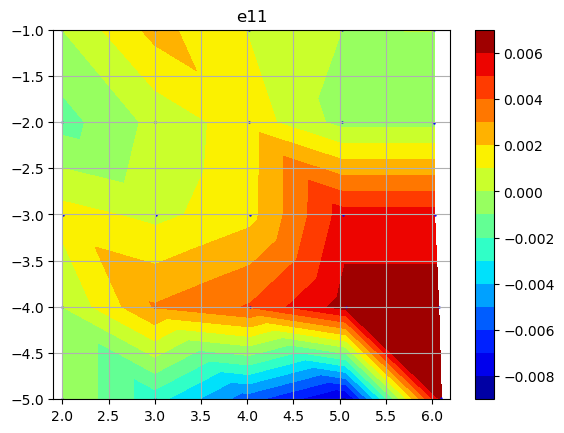

Done.
average_stress =  0.6715921055492522
0.0


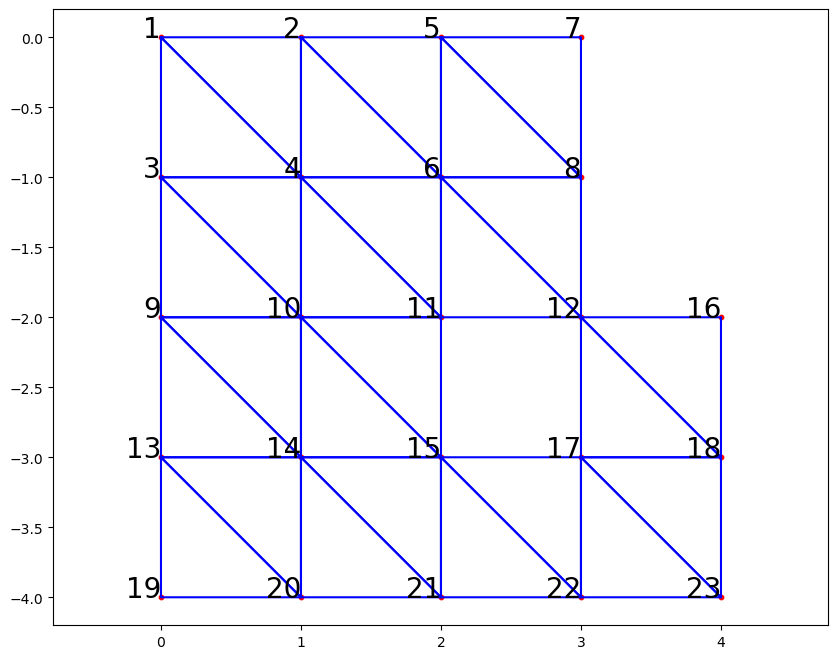

   min strains: e11=-0.01699, e22=-0.3133, e12=-0.05875
   max strains: e11=0.0152, e22=0.09934, e12=0.07728
   min stress:  s11=-17.58, s22=-41.97, s12=-2.259
   max stress:  s11=5.108, s22=13.1, s12=2.972
   average strains: e11=0.001722, e22=-0.09794, e12=0.01531
   average stress:  s11=-5.419, s22=-13.09, s12=0.5887
   average strain/nodes:  s11=2084, s22=5033, s12=226.4
   average strain/nodes:  e11=0.6625, e22=37.67, e12=5.887

** Plot displacement


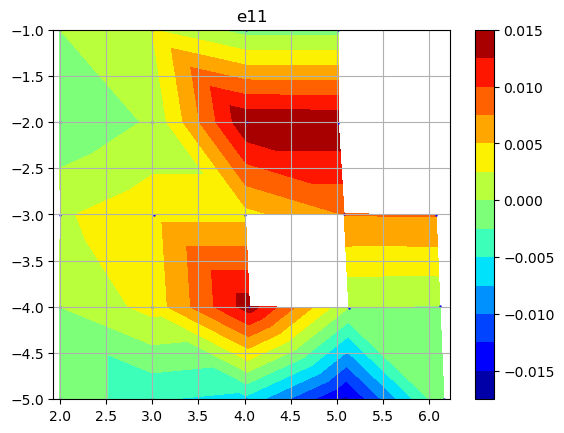

Done.
average_stress =  0.5887378928644126
27.945991581299356
   min strains: e11=-0.008529, e22=-0.2102, e12=-0.05221
   max strains: e11=0.008726, e22=0.07835, e12=0.05184
   min stress:  s11=-11.86, s22=-28.18, s12=-2.008
   max stress:  s11=3.818, s22=10.25, s12=1.994
   average strains: e11=0.0008044, e22=-0.1079, e12=0.02199
   average stress:  s11=-6.117, s22=-14.48, s12=0.8456
   average strain/nodes:  s11=2549, s22=6033, s12=352.3
   average strain/nodes:  e11=0.3352, e22=44.96, e12=9.161

** Plot displacement


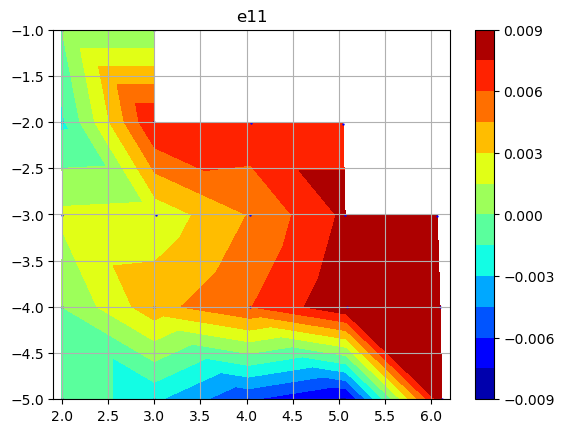

Done.
average_stress =  0.845622807067179
18.061294054946735
   min strains: e11=-0.04411, e22=-0.7115, e12=-0.1717
   max strains: e11=0.04753, e22=0.3129, e12=0.1716
   min stress:  s11=-39.6, s22=-95.16, s12=-6.605
   max stress:  s11=16.26, s22=39.58, s12=6.598
   average strains: e11=0.009034, e22=-0.2051, e12=0.01825
   average stress:  s11=-10.62, s22=-27.09, s12=0.7021
   average strain/nodes:  s11=5898, s22=1.505e+04, s12=390
   average strain/nodes:  e11=5.019, e22=114, e12=10.14

** Plot displacement


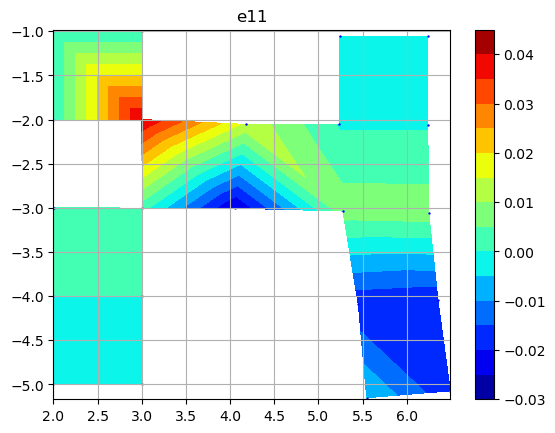

Done.
average_stress =  0.7020763282917605
45.853408767365345


In [125]:
# Initialize the design_space as a 3D matrix
design_space = np.zeros((4, HEIGHT, WIDTH))

design_space2= np.zeros((4, HEIGHT, WIDTH))
design_space3= np.zeros((4, HEIGHT, WIDTH))
design_space4= np.zeros((4, HEIGHT, WIDTH))
# Example design matrix
design_matrix = build_truss_design()

half_matrix = build_half_design_matrix()

full_matrix = np.ones((HEIGHT, WIDTH))

bad_design = build_bad_design_matrix()



# Assign the design matrix to the design_space
design_space[DESIGN, :, :] = design_matrix
design_space2[DESIGN, :, :] = half_matrix
design_space3[DESIGN, :, :] = full_matrix
design_space4[DESIGN, :, :] = bad_design
# Example boundary conditions
design_space[BOUND, 0, 0] = 3
design_space[BOUND, -1, 0] = 3
#design_space[BOUND, -1, -1] = 1

design_space2[BOUND, :, :] = design_space[BOUND, :, :]
design_space3[BOUND, :, :] = design_space[BOUND, :, :]
design_space4[BOUND, :, :] = design_space[BOUND, :, :]

# Example loaded elements

design_space[LOADED_Y, -1, -1] = 10

design_space2[LOADED_Y, -1, -1] = 10
design_space3[LOADED_Y, -1, -1] = 10
design_space4[LOADED_Y, -1, -1] = 10

#print(design_space)

#print(extract_fem_data(design_space))

a,b,c, d = extract_fem_data(design_space3)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(a, b, c, d, True)
init_stress = average_stress
init_strain = average_strain
print("average_stress = ", average_stress)
print(reward_function(smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, init_strain, max_displacement_1, max_displacement_2, init_stress))


a,b,c, d = extract_fem_data(design_space)
plot_mesh(a, b)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function(smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, init_strain, max_displacement_1, max_displacement_2, init_stress))


a,b,c, d = extract_fem_data(design_space2)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function(smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, init_strain, max_displacement_1, max_displacement_2, init_stress))



a,b,c, d = extract_fem_data(design_space4)
smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(a, b, c, d, True)
print("average_stress = ", average_stress)
print(reward_function(smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, init_strain, max_displacement_1, max_displacement_2, init_stress))

In [126]:
def eliminate_isolated_ones(matrix, main_connected_component):
  """
  Eliminates 1s that are not part of the main connected structure.

  Args:
    matrix: A binary matrix (filled with 0s and 1s).
    main_connected_component: A list of tuples representing the coordinates of the main connected component.

  Returns:
    The modified matrix with non-main structure 1s removed.
  """

  rows, cols = matrix.shape

  # Create a set for efficient membership testing
  main_component_set = set(main_connected_component)

  for i in range(rows):
    for j in range(cols):
      if matrix[i, j] == 1 and (i, j) not in main_component_set:
        matrix[i, j] = 0

  return matrix

In [127]:
def get_scatter_coordinates(bound_list, loaded_list):
    """this is a simple function to provide an easy way to get the coordinates
    used for the scatter plot
    -------
    Parameters:\n
    - matrix : numpy.ndarray
        - The design space.
    -------
    Returns:\n
    - x_bound_positions_for_scatter : list
        - the list of needed x coordinates for the scatter plot of the bound nodes
    - y_bound_positions_for_scatter : list
        - the list of needed y coordinates for the scatter plot of the bound nodes
    - x_loaded_positions_for_scatter : list
        - the list of needed x coordinates for the scatter plot of the loaded nodes
    - y_loaded_positions_for_scatter : list
        - the list of needed y coordinates for the scatter plot of the loaded nodes 
    """
    x_bound_for_scatter = [coord[1] for coord in bound_list]
    y_bound_for_scatter = [coord[0] for coord in bound_list]

    x_loaded_for_scatter = [coord[1] for coord in loaded_list]
    y_loaded_for_scatter = [coord[0] for coord in loaded_list]
    return (x_bound_for_scatter, y_bound_for_scatter,
            x_loaded_for_scatter, y_loaded_for_scatter)

In [128]:
def get_observation_space_range(height,width):
        length = 4*height * width
        dim = height * width
        design_space_low = np.zeros(4*height*width)
        design_space_high = np.zeros(4*height*width)
        for i in range(length):
            if i / dim < 1:
                design_space_low[i] = 0
                design_space_high[i] = 1
            elif i / dim < 2:
                design_space_low[i] = 0
                design_space_high[i] = 3
            elif i / dim < 3:
                design_space_low[i] = -1000
                design_space_high[i] = 1000
            else:
                design_space_low[i] = -1000
                design_space_high[i] = 1000
        shape = (length,)
        return design_space_low, design_space_high, shape

In [129]:
# class TopOptEnv(gym.Env):
#     metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

#     def __init__(self, mode="train", threshold=0.3, 
#                  bound_nodes_list=bound_nodes_list, 
#                  force_nodes_list=loaded_nodes_list, 
#                  height=HEIGHT, width=WIDTH):
#         # The constructor of the environment
#         super().__init__()

#         self.mode = mode
#         self.threshold = threshold

#         self.height = height
#         self.width = width
        
        
#         self.bound_nodes_list = bound_nodes_list
#         self.force_nodes_list = force_nodes_list
#         self.initial_max_strain = 0
#         self.design_space = np.zeros((4, self.height, self.width))
#         low, high, o_space_shape = get_observation_space_range(self.height, self.width)

#         self.action_space = gym.spaces.Discrete(self.height * self.width)
#         self.observation_space = gym.spaces.Box(low=low, 
#                                                 high=high, 
#                                                 shape=o_space_shape, 
#                                                 dtype=int)
        
#         # A Dictionary is used to map each coordinate tuple of the designspace
#         # to a singular distinct integer for use in the optimization
#         # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes=(height,width)
#         self._actions_to_coordinates = {}  
#         k=0
#         for i in range(self.height):
#             for j in range(self.width):
#                 self._actions_to_coordinates[k] = (i,j)
#                 k += 1
        
#         self.reward = 0
#         self.step_count = 0
#         self.episode_count = 0

#         self.reset()
        
#     def _is_illegal_action(self, action):
#         bound_matrix = self.design_space[BOUND, :, :]
#         force_matrix = np.logical_or(self.design_space[LOADED_X, :, :], 
#                                      self.design_space[LOADED_Y,:,:]).astype(int)
#         design_matrix = self.design_space[DESIGN, :, :]

       
#         # Check if the selected Action has already been performed on this state
#         if action in self.performed_actions:
#             if self.mode == "eval":
#                 print("Action already performed")
#             return True
#         #check if the selected Node is either bound or force node
#         if bound_matrix[self._actions_to_coordinates[action]] != 0:
#             if self.mode == "eval":
#                 print("Tried removing Bound Node")
#             return True
#         if force_matrix[self._actions_to_coordinates[action]] != 0:
#             if self.mode == "eval":
#                 print("Tried removing Loaded Node")
#             return True
#         #Check if the selected Node is already removed
#         if design_matrix[self._actions_to_coordinates[action]] < 1:
#             if self.mode == "eval":
#                 print("Tried removing Empty Node")
#             return True
#         if not is_continuous(design_matrix, self.dfs_result):
#             print("Not continuous")
#             return True

#     def step(self, action):
#         #self.print_design(self)
#         design_matrix = self.design_space[DESIGN, :,:]
        
#         self.step_count += 1
#         terminated = False
#         self.dfs_result = dfs(design_matrix, self.bound_nodes_list + self.force_nodes_list)

#         if self._is_illegal_action(action):
#             reward = -(self.height * self.width) *10
#             terminated = True
#             #print("Illegal Action")
#             # print("Action: ", self._actions_to_coordinates[action])
#             return (self.design_space, reward, 
#                     terminated, False, self.get_info())
        
        
        
        
#         #self.last_compliance = self.compliance

#         self._remove_node(action)
#         self.dfs_result = dfs(design_matrix, self.bound_nodes_list + self.force_nodes_list)
#         if not is_continuous(design_matrix, self.dfs_result):
#             terminated = True
#             #print("Illegal Action")
#             # print("Action: ", self._actions_to_coordinates[action])
#             reward = -(self.height * self.width) *10
#             return (self.design_space, reward, 
#                     terminated, False, self.get_info())
        
#         #eliminate_isolated_ones(design_matrix, self.dfs_result)
#         if self.episode_count % 5000 == 0:
#             self.print_design()

#         self.constraint = (self.design_space[DESIGN, :, :].sum() / 
#                           (self.height * self.width))


#         self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
        
        
#         try:
#             self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2 = FEM(self.nodes, self.elements , self.boundary_conditions, self.node_map, False)
#         except np.linalg.LinAlgError as e:
#             terminated = True
#             self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#             plot_mesh(self.nodes, self.elements)
#             print("target coordinates:", self.bound_nodes_list + self.force_nodes_list)
#             print("iscontinuus?:" + is_continuous(self.design_space[DESIGN, :, :], self.dfs_result))
#             print("n", self.design_space[DESIGN, :, :])
#             raise
#         except ValueError as e:
#             terminated = True
#             #self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#             #plot_mesh(self.nodes, self.elements)
#             print("v", self.design_space[DESIGN, :, :])
#             print(self._actions_to_coordinates[action])

#             print("Episode: ", self.episode_count)
#             raise
        
#         self.current_reward = reward_function(self.smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, average_strain, self.init_strain, self.max_displacement_1, self.max_displacement_2, self.init_stress)
#         self.reward += self.current_reward

#         self.performed_actions.append(action)

#         if self.constraint < self.threshold:
#             terminated = True
#             if self.mode == "train":
#                 self.current_reward += 100

#         self.design_space[DESIGN, :, :] = design_matrix





#         return self.design_space.flatten(), self.current_reward, terminated, False, self.get_info()



#     def _remove_node(self, action):
#         design_matrix = self.design_space[DESIGN, :, :]
#         design_matrix[self._actions_to_coordinates[action]] = 0    
#         self.design_space[DESIGN, :, :] = design_matrix
    



#     def reset(self, seed=None):
#         # The reset function of the environment

#         super().reset(seed=seed)
#         self.episode_count += 1
#         self.step_count = 0
#         self.reward = 0
#         self.performed_actions = []
#         self.design_space = np.zeros((4, self.height, self.width))
#         self.design_space[DESIGN, :, :] += 1

#         design_matrix = self.design_space[DESIGN, :, :]
#         bound_matrix = self.design_space[BOUND, :,:]
#         force_x_matrix = self.design_space[LOADED_X, :,:]
#         force_y_matrix = self.design_space[LOADED_Y, :,:]

#         if self.mode == "train":
#             self.bound_nodes_list = []
#             self.bound_nodes_list.append(self.generate_random_coordinate()) 
#             self.bound_nodes_list.append(self.generate_random_coordinate()) 

#             self.force_nodes_list = []
#             self.force_nodes_list.append(self.generate_random_coordinate())
        
#         if self.mode == "eval":
#             self.bound_nodes_list = bound_nodes_list
#             self.force_nodes_list = loaded_nodes_list
        
#         for coord in convert_all(self.bound_nodes_list, (self.height, self.width)):
#             bound_matrix[coord] = 3
#         for coord in convert_all(self.force_nodes_list, (self.height, self.width)):
#             force_y_matrix[coord] = 10  

        
        


        
#         # self.compliance = self.initial_compliance
#         # self.last_compliance = self.initial_compliance

#         self.design_space[DESIGN, :, :] = design_matrix
#         self.design_space[BOUND, :, :] = bound_matrix
#         self.design_space[LOADED_Y, :,:] = force_y_matrix
#         self.design_space[LOADED_X, :,:] = force_x_matrix

#         # print("\n\nReset Debug ====================================")
#         # print("items in self.bound_nodes_list", len(self.bound_nodes_list))
#         # print("bound_nodes_list", self.bound_nodes_list)
#         # print("Initial Compliance:\n", self.initial_compliance)
#         # print("design_matrix:\n", design_matrix)
#         # print("design_space[:,:,_DESIGN]:\n", self.design_space[:,:, _DESIGN])
#         # print("bound_matrix:\n", bound_matrix)
#         # print("design_space[:,:,_BOUND]:\n", self.design_space[:,:, _BOUND])
#         # print("force_matrix:\n", force_matrix)
#         # print("design_space[:,:,_FORCE]:\n", self.design_space[:,:, _FORCE])
#         # print("compliance_matrix:\n", compliance_matrix)
#         # print("Initial Reward:\n", self.reward)

#         self.nodes, self.elements , self.boundary_conditions, self.node_map = extract_fem_data(self.design_space)
#         smax, self.emax, self.avg_u1, self.avg_u2, self.element_count, self.average_stress, self.average_strain, self.max_displacement_1, self.max_displacement_2 = FEM(self.nodes, self.elements , self.boundary_conditions, self.node_map, False)
#         self.init_stress = smax
#         self.init_strain = self.average_stress

#         return self.design_space.flatten(), self.get_info()



#     def is_valid_coordinate(self, coord, node_lists):
#     # Check adjacent positions
#         checking_positions = [
#             (coord[0], coord[1]),  # Current
#             (coord[0] - 1, coord[1]),  # Left
#             (coord[0] + 1, coord[1]),  # Right
#             (coord[0], coord[1] - 1),  # Up
#             (coord[0], coord[1] + 1),  # Down
#         ]
#         # Check if any adjacent position is in the node lists
#         for pos in checking_positions:
#             if any(pos in node_list for node_list in node_lists):
#                 return True
#         return False

#     def generate_random_coordinate(self):
#         axis = random.randint(0, 3)
#         if axis == 0:
#             coord = random.randint(0, self.height-1), 0  # Left edge
#         elif axis == 1:
#             coord = 0, random.randint(0, self.width-1)  # Top edge
#         elif axis == 2:
#             coord = random.randint(0, self.height-1), self.width-1  # Right edge
#         else:
#             coord = self.height-1, random.randint(0, self.width-1)  # Bottom edge

#         # Check if the coordinate is in the lists or next to any node in the lists
#         comp_list = [self.bound_nodes_list, self.force_nodes_list]
    
#         if (coord in self.bound_nodes_list or 
#             coord in self.force_nodes_list or 
#             self.is_valid_coordinate(coord, comp_list)):
        
#             return self.generate_random_coordinate()
#         else:
#             return coord
    

    
#     def print_design(self, mode="human"):
#         # This function is used to render the environment
#         # This function is not necessary for the optimization
#         print("current Design")
#         print(self.force_nodes_list)
#         fig, ax = plt.subplots()
#         ax.imshow(self.design_space[DESIGN, :, :])
#         xb, yb, xl, yl = get_scatter_coordinates(self.bound_nodes_list, 
#                                                  self.force_nodes_list)
#         ax.scatter(xb, yb, s=20, color='k', marker='x')
#         ax.scatter(xl, yl, s=20, color='k', marker='$↓$')
#         plt.show()


#     def get_info(self):
#         # This function returns the information about the environment
#         # This function is used to monitor the environment
#         # The information should be a dictionary
#         # The dictionary should contain the following keys:
#         # - step_count: the number of steps that have been executed
#         # - current Reward: the reward of the current state
#         # - design_space: the current state of the environment
#         return {"step_count": self.step_count, 
#                 "current_reward": self.reward,
#                 "design_space": self.design_space,
#                 }


In [ ]:
class TopOptEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, mode="train", threshold=0.3, bound_nodes_list=bound_nodes_list, force_nodes_list=loaded_nodes_list, height=HEIGHT, width=WIDTH):
        # The constructor of the environment
        super().__init__()

        self.mode = mode
        self.threshold = threshold

        self.height = height
        self.width = width
        
        self.bound_nodes_list = bound_nodes_list
        self.force_nodes_list = force_nodes_list
        self.inital_avg_strain = 0
        self.init_stress = 0
        self.design_space = np.zeros((4, self.height, self.width))
        self.design_space[DESIGN, :, :] += 1
        low, high, o_space_shape = get_observation_space_range(self.height, self.width)
        self.observation_space = gym.spaces.Box(low=low, 
                                                high=high, 
                                                shape=o_space_shape, 
                                                dtype=int)        
        self.action_space = gym.spaces.Discrete(self.height * self.width)

        
        # A Dictionary is used to map each coordinate tuple of the designspace
        # to a singular distinct integer for use in the optimization
        # 0 = (0,0), 1 = (0,1), 2 = (0,2), ... , number_of_nodes=(height,width)
        self._actions_to_coordinates = {}  
        k=0
        for i in range(self.height):
            for j in range(self.width):
                self._actions_to_coordinates[k] = (i,j)
                k += 1
        
        self.reward = 0
        self.accumulated_reward = 0
        self.step_count = 0
        self.episode_count = 0

        self.reset()
    
    def _is_illegal_action(self, action):
        bound_matrix = self.design_space[BOUND, :, :]
        force_matrix = np.logical_or(self.design_space[LOADED_X, :, :], 
                                     self.design_space[LOADED_Y,:,:]).astype(int)
        design_matrix = self.design_space[DESIGN, :, :]

        # Check if the selected Action has already been performed on this state
        if action in self.performed_actions:
            if self.mode == "eval":
                print("Action already performed")
            return True
        #check if the selected Node is either bound or force node
        if bound_matrix[self._actions_to_coordinates[action]] != 0:
            if self.mode == "eval":
                print("Tried removing Bound Node")
            return True
        if force_matrix[self._actions_to_coordinates[action]] != 0:
            if self.mode == "eval":
                print("Tried removing Loaded Node")
            return True
        #Check if the selected Node is already removed
        if design_matrix[self._actions_to_coordinates[action]] < 1:
            if self.mode == "eval":
                print("Tried removing Empty Node")
            return True
        if not is_continuous(design_matrix, self.dfs_result):
            print("Not continuous")
            return True
    def step(self, action):

        self.step_count += 1
        terminated = False
        self.dfs_result = dfs(self.design_space[DESIGN, :, :], self.bound_nodes_list + self.force_nodes_list)
        if self._is_illegal_action(action):
            reward = -(self.height * self.width) *10
            terminated = True
            return (self.design_space.flatten(), reward, 
                    terminated, False, self.get_info())
        self._remove_node(action)
        self.dfs_result = dfs(self.design_space[DESIGN, :, :], self.bound_nodes_list + self.force_nodes_list)
        if not is_continuous(self.design_space[DESIGN, :, :], self.dfs_result):
            terminated = True
            reward = -(self.height * self.width) *10
            return (self.design_space.flatten(), reward, 
                    terminated, False, self.get_info())
        

        nodes, elements , boundary_conditions, node_map = extract_fem_data(self.design_space)

        smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(nodes, elements , boundary_conditions, node_map, False)
        self.reward = reward_function(smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, self.inital_avg_strain, max_displacement_1, max_displacement_2, self.init_stress)
        self.accumulated_reward += self.reward
        self.performed_actions.append(action)
        constraint = (self.design_space[DESIGN, :, :].sum() / 
                          (self.height * self.width))
        if constraint < self.threshold:
            terminated = True
            if self.mode == "train":
                self.reward += 100

        if self.episode_count % 5000 == 0:
            self.print_design()
            print("curr_reward", self.reward)
            print("accumulated_reward", self.accumulated_reward)
        return self.design_space.flatten(), self.reward, terminated, False, self.get_info()
        
    def _remove_node(self, action):	
        design_matrix = self.design_space[DESIGN, :, :]
        design_matrix[self._actions_to_coordinates[action]] = 0    
        self.design_space[DESIGN, :, :] = design_matrix
    
    def reset(self, seed=None):
        super().reset(seed=seed)
        self.episode_count += 1
        self.step_count = 0
        self.reward = 0
        self.performed_actions = []
        self.design_space = np.zeros((4, self.height, self.width))
        self.design_space[DESIGN, :, :] += 1
        
        design_matrix = self.design_space[DESIGN, :, :]
        bound_matrix = self.design_space[BOUND, :,:]
        force_x_matrix = self.design_space[LOADED_X, :,:]
        force_y_matrix = self.design_space[LOADED_Y, :,:]

        if self.mode == "train":
            self.bound_nodes_list = []
            self.force_nodes_list = []
            
            self.bound_nodes_list.append(self.generate_random_coordinate()) 
            self.bound_nodes_list.append(self.generate_random_coordinate()) 
            self.force_nodes_list.append(self.generate_random_coordinate())
        
        if self.mode == "eval":
            self.bound_nodes_list = self.bound_nodes_list
            self.force_nodes_list = self.loaded_nodes_list
        
        for coord in convert_all(self.bound_nodes_list, (self.height, self.width)):
            bound_matrix[coord] = 3
        for coord in convert_all(self.force_nodes_list, (self.height, self.width)):
            force_y_matrix[coord] = 10

        self.design_space[DESIGN, :, :] = design_matrix
        self.design_space[BOUND, :, :] = bound_matrix
        self.design_space[LOADED_Y, :,:] = force_y_matrix
        self.design_space[LOADED_X, :,:] = force_x_matrix

        nodes, elements , boundary_conditions, node_map = extract_fem_data(self.design_space)
        smax, emax, avg_u1, avg_u2, element_count, average_stress, average_strain, max_displacement_1, max_displacement_2 = FEM(nodes, elements , boundary_conditions, node_map, False)
        self.init_strain = average_strain
        return self.design_space.flatten(), self.get_info()

    def is_valid_coordinate(self, coord, node_lists):
    # Check adjacent positions
        checking_positions = [
            (coord[0], coord[1]),  # Current
            (coord[0] - 1, coord[1]),  # Left
            (coord[0] + 1, coord[1]),  # Right
            (coord[0], coord[1] - 1),  # Up
            (coord[0], coord[1] + 1),  # Down
        ]
        # Check if any adjacent position is in the node lists
        for pos in checking_positions:
            if any(pos in node_list for node_list in node_lists):
                return True
        return False

    def generate_random_coordinate(self):
        axis = random.randint(0, 3)
        if axis == 0:
            coord = random.randint(0, self.height-1), 0  # Left edge
        elif axis == 1:
            coord = 0, random.randint(0, self.width-1)  # Top edge
        elif axis == 2:
            coord = random.randint(0, self.height-1), self.width-1  # Right edge
        else:
            coord = self.height-1, random.randint(0, self.width-1)  # Bottom edge

        # Check if the coordinate is in the lists or next to any node in the lists
        comp_list = [self.bound_nodes_list, self.force_nodes_list]
    
        if (coord in self.bound_nodes_list or 
            coord in self.force_nodes_list or 
            self.is_valid_coordinate(coord, comp_list)):
        
            return self.generate_random_coordinate()
        else:
            return coord

    def print_design(self, mode="human"):
        # This function is used to render the environment
        # This function is not necessary for the optimization
        print("current Design")
        print(self.force_nodes_list)
        fig, ax = plt.subplots()
        ax.imshow(self.design_space[DESIGN, :, :])
        xb, yb, xl, yl = get_scatter_coordinates(self.bound_nodes_list, 
                                                 self.force_nodes_list)
        ax.scatter(xb, yb, s=20, color='k', marker='x')
        ax.scatter(xl, yl, s=20, color='k', marker='$↓$')
        plt.show()

    def get_info(self):
        # This function returns the information about the environment
        # This function is used to monitor the environment
        # The information should be a dictionary
        # The dictionary should contain the following keys:
        # - step_count: the number of steps that have been executed
        # - current Reward: the reward of the current state
        # - design_space: the current state of the environment
        return {"step_count": self.step_count, 
                "current_reward": self.reward,
                "design_space": self.design_space,
                }


In [131]:
def vecenv_render(env):
    plt.close()
    design_spaces = env.env_method("get_info")
    fig, axs = plt.subplots(1, NUMBER_SUBPROCESSES)
    fig.set_size_inches(20, 3)

    fig.subplots_adjust(hspace=0.05)
    
    
    for i in range(NUMBER_SUBPROCESSES * 1):
        row = i // NUMBER_SUBPROCESSES
        col = i % NUMBER_SUBPROCESSES
        
        if row == 0:
            space_index = i
        else:
            space_index = i - NUMBER_SUBPROCESSES

        # if len(design_spaces[space_index]["design_space"].shape) != 2:
        #     raise ValueError(f"Expected a 2D array, but got shape {design_spaces[space_index]['design_space'].shape}")


        current_design_space = design_spaces[space_index]["design_space"]
        current_bound_matrix = current_design_space[BOUND, :, :, ]
        current_force_matrix = np.logical_or(current_design_space[LOADED_X, :, :], 
                                     current_design_space[LOADED_Y,:,:]).astype(int)
        
        #print(current_bound_matrix)
        current_bound_list = matrix_to_node_list(current_bound_matrix)
        current_force_list = matrix_to_node_list(current_force_matrix)
        
        #print(current_bound_list, "\n", current_force_list)
        if row == 0:
            axs[col].imshow(current_design_space[DESIGN, :, :], 
                                 vmin=0, vmax=1)
            current_reward = design_spaces[space_index]["current_reward"]
            title = f"{i + 1}\nReward= {round(current_reward, 1)}"
        # else:
        #     axs[row, col].imshow(current_design_space[:, :, _COMPLIANCE], 
        #                          vmin=0, vmax=1)
        #     current_compliance = design_spaces[space_index]["compliance"]
        #     title = f"Compliance= {round(current_compliance, 1)}"
        
        xb, yb, xl, yl = get_scatter_coordinates(current_bound_list, 
                                                 current_force_list)
        axs[col].scatter(xb, yb, s=20, color='k', marker='x')
        axs[col].scatter(xl, yl, s=20, color='k', marker='$↓$')
        axs[col].set_title(title, fontsize=11, pad=10) 
    plt.show()
    


def matrix_to_node_list(matrix):
    """
    Finds the coordinates of all the 1s in a given matrix.

    :param matrix: A 2D list or numpy array containing 0s and 1s.
    :return: A list of tuples, where each tuple represents the 
    coordinates (row, column) of a 1 in the matrix.
    """
    coordinates = []
    for i, row in enumerate(matrix):
        for j, value in enumerate(row):
            if value != 0:
                coordinates.append((i, j))
    return coordinates

def node_list_to_matrix(coordinates, rows, cols):
    """
    Creates a matrix from a list of coordinates, setting the positions 
    of the coordinates to 1.

    :param coordinates: A list of tuples, where each tuple represents 
    the coordinates (row, column) of a 1.
    :param rows: The number of rows in the matrix.
    :param cols: The number of columns in the matrix.
    :return: A 2D list (matrix) with 1s at the specified coordinates and 
    0s elsewhere.
    """
    matrix = [[0 for _ in range(cols)] for _ in range(rows)]
    for (i, j) in coordinates:
        matrix[i][j] = 1
    return matrix

In [132]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` 
    steps)based on the training reward (in practice, we recommend using 
    ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be 
    saved. It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)s
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        print("callback baby")
        if self.save_path is not None:
            # os.makedirs(self.save_path, exist_ok=True
            return

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            print("hello hello")
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print("--------------------------------------------------")
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                if NUMBER_SUBPROCESSES > 1:
                    vecenv_render(env)
                else:
                    env.print_design()
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
                    

        return True

In [133]:
def make_env():
    return TopOptEnv()

In [134]:
if NUMBER_SUBPROCESSES == 1:
    env = make_env()
    #check_env(env, warn=True)
    env = Monitor(env, LOG_DIR)
if NUMBER_SUBPROCESSES > 1:
    env = SubprocVecEnv([make_env for _ in range(NUMBER_SUBPROCESSES)])
    env = VecMonitor(env, LOG_DIR)

callback = SaveOnBestTrainingRewardCallback(check_freq=10000, log_dir=LOG_DIR)

sess = tf.compat.v1.Session()
file_writer = tf.summary.create_file_writer(TS_BOARD_DIR)
with file_writer.as_default():
    tf.summary.graph(sess.graph)


In [135]:
%tensorboard --logdir /home/adrian_2/Documents/Bachelorarbeit/topology_optimization_RL_BA/src/ts_board

Reusing TensorBoard on port 6006 (pid 17836), started 7:40:06 ago. (Use '!kill 17836' to kill it.)

In [136]:
start=time.time()
try:
    model = PPO("MlpPolicy", env, tensorboard_log=TS_BOARD_DIR).learn(total_timesteps=TIMESTEPS, callback=callback)
except ValueError as e:
    print("reward" + str(env.current_reward))
    print("DESIGN" + str(env.design_space[DESIGN, :, :]))
    print("bound" + str(env.design_space[BOUND, :, :]))
    print("force" + str(env.design_space[LOADED_Y, :, :]))
    print(e)
end=time.time()   
print("Elapsed Time = " + str(end-start))

callback baby


AttributeError: 'TopOptEnv' object has no attribute 'dfs_result'

In [ ]:
#TODO REWARD FUNCTION : LESS CHANGE IN STRAIN OR STRESS BETWEEN STEPS THE BETTER

In [ ]:
#TODO CATCH singular Matrices before they happen

#TODO DESIGN SPACE KLEINER
#TODO LERNPROZESS SIMILIEREN
#TODO 

Step 1
Action:  3
Reward:  251.9418064140953
current Design
[(3, 3)]


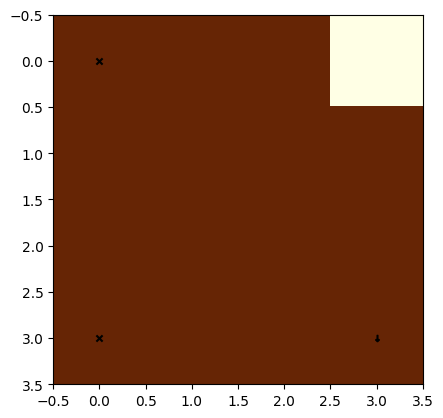

Step 2
Action:  1
Reward:  503.8836128281906
current Design
[(3, 3)]


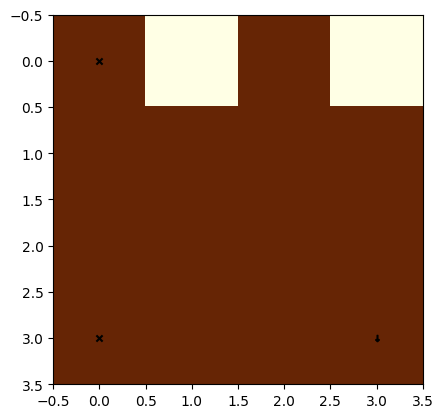

Step 3
Action:  5
Reward:  755.825419242286
current Design
[(3, 3)]


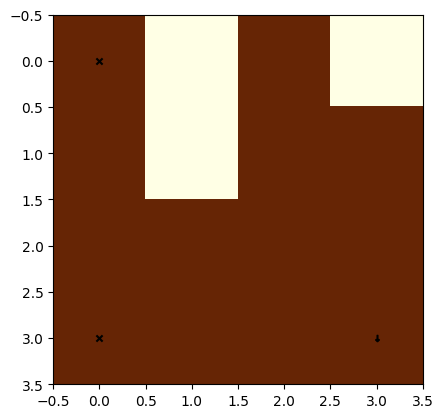

Step 4
Action:  7
Reward:  1007.7672256563812
current Design
[(3, 3)]


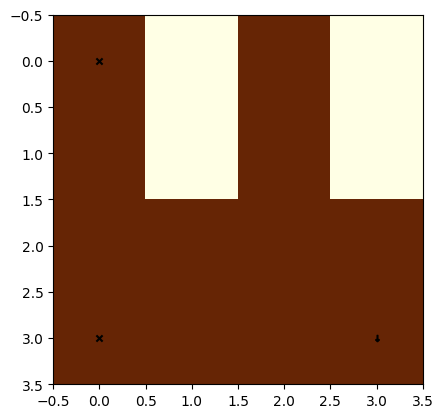

Step 5
Action:  8
Reward:  -160
current Design
[(3, 3)]


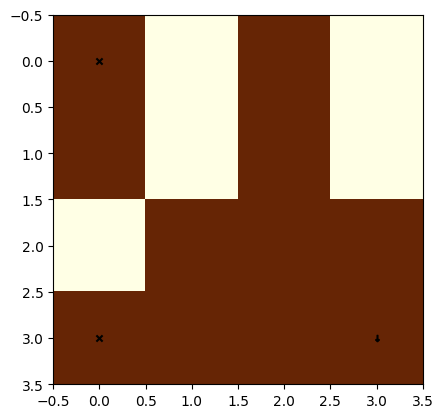

Goal reached! reward= -160
current Design
[(3, 3)]


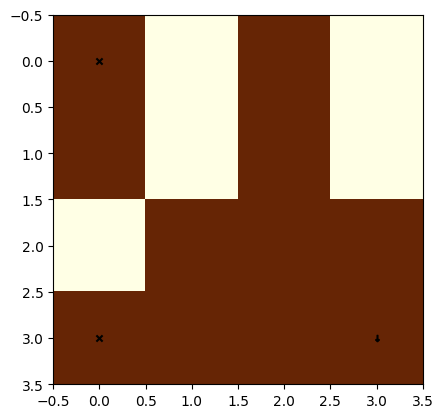

In [ ]:

# Ensure the environment is properly closed before reinitializing
env.close()
bound_nodes_list = [(0, 0), (HEIGHT-1, 0)]
"""A list containing the coordinates of the nodes that are bound in the 
design space."""

loaded_nodes_list = [(HEIGHT-1, WIDTH-1)]

# Initialize the environment
env = TopOptEnv(mode="eval", threshold=0.2,bound_nodes_list=bound_nodes_list, force_nodes_list=loaded_nodes_list)

# Define the model path using a raw string
model_path = r"./log/best_model.zip"

# Check if the file exists and is accessible
if not os.path.exists(model_path):
    raise FileNotFoundError(f"The model file {model_path} does not exist.")
if not os.access(model_path, os.R_OK):
    raise PermissionError(f"The model file {model_path} is not readable.")

# Load the model
try:
    model_best = PPO.load(model_path, env=env)
except PermissionError as e:
    print(f"PermissionError: {e}")
    print("Please check the file permissions and ensure no other application is using the file.")
    raise

# Reset the environment
obs, _ = env.reset()
i = 0

# Run the evaluation loop
while i < 1000:
    action, _states = model_best.predict(obs)
    action = action.item()

    obs, rewards, dones, _, info = env.step(action)
    if i % 1 == 0:
        print(f"Step {i + 1}")
        print("Action: ", action)  # added Console Outputs for better understanding
        print("Reward: ", rewards)
        env.print_design()
    if dones:
        print("Goal reached!", "reward=", rewards)
        env.print_design()
        break
    i += 1

In [ ]:
#TODO: Reward nicht Akummulierend
#TODO: 4x4 kleine Matrix Debuggen


In [ ]:
env = TopOptEnv(mode = eval, threshold=0.2)
env.print_design()


init:strain:		 0.671592
max:strain:		 0.072187
average_strain:		 0.0174
strain ratio:		 0.671592 / 0.01735  =  533.352727
Material ratio:		 32 - 30 / 32  =  0.0625
reward = 278.864511915092
current returned Reward:		 251.941806
current self.reward:		 251.941806
init:strain:		 0.671592
max:strain:		 0.072188
average_strain:		 0.0184
strain ratio:		 0.671592 / 0.018437  =  501.929015
Material ratio:		 32 - 28 / 32  =  0.125
reward = 493.94524643983897
current returned Reward:		 503.883613
current self.reward:		 755.825419
init:strain:		 0.671592
max:strain:		 0.073158
average_strain:		 0.0184
strain ratio:		 0.671592 / 0.018401  =  502.905078
Material ratio:		 32 - 26 / 32  =  0.1875
reward = 743.8022823036476
current returned Reward:		 755.825419
current self.reward:		 1511.650838
current Design
[(3, 3)]


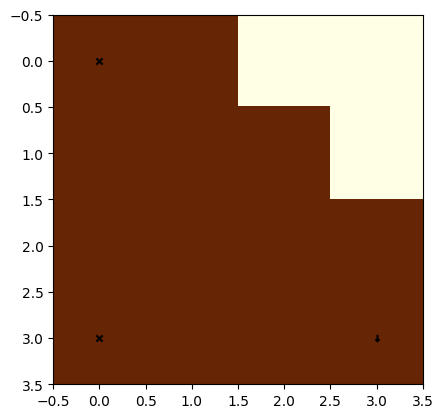

init:strain:		 0.671592
max:strain:		 0.079086
average_strain:		 0.0173
strain ratio:		 0.671592 / 0.017259  =  536.175625
Material ratio:		 32 - 30 / 32  =  0.0625
reward = 281.8242400688495
current returned Reward:		 251.941806
current self.reward:		 251.941806
init:strain:		 0.671592
max:strain:		 0.08778
average_strain:		 0.0178
strain ratio:		 0.671592 / 0.017849  =  518.465454
Material ratio:		 32 - 28 / 32  =  0.125
reward = 527.0281997934192
current returned Reward:		 503.883613
current self.reward:		 755.825419
init:strain:		 0.671592
max:strain:		 0.185975
average_strain:		 0.0203
strain ratio:		 0.671592 / 0.020343  =  454.904296
Material ratio:		 32 - 26 / 32  =  0.1875
reward = 608.5910212414458
current returned Reward:		 755.825419
current self.reward:		 1511.650838
current Design
[(3, 3)]


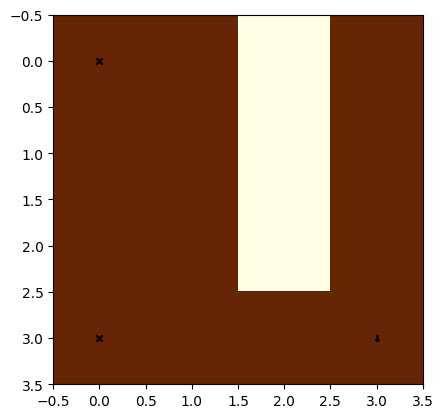

init:strain:		 0.671592
max:strain:		 0.066403
average_strain:		 0.0206
strain ratio:		 0.671592 / 0.020641  =  448.335684
Material ratio:		 32 - 30 / 32  =  0.0625
reward = 197.04745237221724
current returned Reward:		 251.941806
current self.reward:		 251.941806
init:strain:		 0.671592
max:strain:		 0.064553
average_strain:		 0.0187
strain ratio:		 0.671592 / 0.018717  =  494.414015
Material ratio:		 32 - 28 / 32  =  0.125
reward = 479.2650421557408
current returned Reward:		 503.883613
current self.reward:		 755.825419
init:strain:		 0.671592
max:strain:		 0.29629
average_strain:		 0.0189
strain ratio:		 0.671592 / 0.018856  =  490.774948
Material ratio:		 32 - 26 / 32  =  0.1875
reward = 708.3538127909536
current returned Reward:		 755.825419
current self.reward:		 1511.650838
current Design
[(3, 3)]


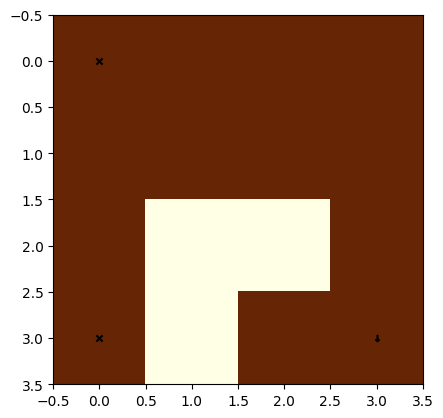

In [ ]:
def normalized_element_count(height, width, element_count):
    max_allowed_elements = height * width * 2
    return (max_allowed_elements - element_count) / max_allowed_elements

def print_env_stats(env, rounding = 6, reward= 0):
    print("init:strain:\t\t", round(env.init_strain, rounding))
    print("max:strain:\t\t", round(env.emax, rounding))
    print("average_strain:\t\t", round(env.average_strain, 4))
    print("strain ratio:\t\t", round(env.init_strain, rounding), "/", round(env.average_strain,rounding), " = ", round(env.init_stress/abs(env.average_strain),rounding))
    print("Material ratio:\t\t" , round((env.height * env.width * 2), rounding), "-", round(env.element_count,rounding), "/", round((env.height * env.width* 2), rounding), " = ", round(normalized_element_count(env.height, env.width, env.element_count),rounding ))
    print("reward =", reward_function(env.smax, env.emax, env.avg_u1, env.avg_u2, env.element_count, env.average_stress, env.average_strain, env.init_strain, env.max_displacement_1, env.max_displacement_2, env.init_stress))
    print("current returned Reward:\t\t", round(reward, rounding))
    print("current self.reward:\t\t", round(env.reward, rounding))

env = TopOptEnv(mode = eval, threshold=0.2)

obs, reward, dones, _, info = env.step(WIDTH-2)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH-1)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(2*WIDTH-1)
print_env_stats(env, reward=reward)
env.print_design()
env.close()


env = TopOptEnv(mode = eval, threshold=0.2)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2)))
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2))- WIDTH)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step((round((0.5*WIDTH*HEIGHT)-2))+ WIDTH)
print_env_stats(env, reward=reward)
env.print_design()
env.close()


env = TopOptEnv(mode = eval, threshold=0.2)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-3)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-3-WIDTH)
print_env_stats(env, reward=reward)
obs, reward, dones, _, info = env.step(WIDTH*HEIGHT-2-WIDTH)
print_env_stats(env, reward=reward)
env.print_design()
env.close()

In [ ]:
env = TopOptEnv(mode = eval, threshold=0.2)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(10)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(91)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.step(98)
print("current Reward: ", env.current_reward)
print("accumulated Reward: ", env.reward)
env.print_design()

In [ ]:
matrix = [[1, 1, 1, 1],
          [1, 1, 0, 0],
          [0, 1, 0, 1],
          [1, 1, 0, 1]]
print(is_continuous(matrix, [(0, 0), (0, 3), (3, 3)]))  # True

In [ ]:
#TODO remove illegal actions from the actions space
